# Modelling-Regression

## Import Libraries

In [1]:
# core
import pandas as pd
import numpy as np

# sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# distributions
from scipy.stats import uniform

# plotting
import matplotlib.pyplot as plt

## Load Data

In [2]:
data = pd.read_csv("../data/processed/final.csv")
sp_lag_1 = pd.read_csv("../data/processed/spatial_lag_1st.csv")
sp_lag_2 = pd.read_csv("../data/processed/spatial_lag_2nd.csv")
sp_lag_3 = pd.read_csv("../data/processed/spatial_lag_3rd.csv")

crops = ["bean", "carrot", "cassava", "chickpea", "citrus", "coffee", "groundnut", "maize", "soy", "sugarcane", "tomato", "wheat"]
others = ["perc_treecover", "perm_water", "cropland", "pasture", "travel_min", "near_road", "mean_elev", "sd_elev"]

In [3]:
data.columns

Index(['row', 'col', 'long', 'lat', 'bean', 'carrot', 'cassava', 'chickpea',
       'citrus', 'coffee', 'groundnut', 'maize', 'soy', 'sugarcane', 'tomato',
       'wheat', 'perc_treecover', 'perm_water', 'travel_min', 'defor_2001',
       'defor_2002', 'defor_2003', 'defor_2004', 'defor_2005', 'defor_2006',
       'defor_2007', 'defor_2008', 'defor_2009', 'defor_2010', 'defor_2011',
       'defor_2012', 'defor_2013', 'defor_2014', 'defor_2015', 'defor_2016',
       'defor_2017', 'defor_2018', 'wdpa_1990', 'wdpa_1991', 'wdpa_1993',
       'wdpa_1994', 'wdpa_1995', 'wdpa_1996', 'wdpa_1997', 'wdpa_1998',
       'wdpa_1999', 'wdpa_2000', 'wdpa_2001', 'wdpa_2002', 'wdpa_2003',
       'wdpa_2004', 'wdpa_2005', 'wdpa_2006', 'wdpa_2007', 'wdpa_2008',
       'wdpa_2009', 'wdpa_2010', 'wdpa_2011', 'wdpa_2012', 'wdpa_2014',
       'wdpa_2015', 'wdpa_2017', 'wdpa_2018', 'chirps_2001', 'chirps_2002',
       'chirps_2003', 'chirps_2004', 'chirps_2005', 'chirps_2006',
       'chirps_2007', 'chirps_20

## Feature Matrix (Temporal and Constant)

In [4]:
def build_x_temporal(n_years, defor_multiplier, other_multiplier = 1):
    # define X_temporal
    X_temporal = np.zeros((n_years, len(data), 16))
    
    # define data lists
    data_lst = [data, sp_lag_1, sp_lag_2, sp_lag_3]
    data_suffix = ["", "_lag_1st_order", "_lag_2nd_order", "_lag_3rd_order"]
    
    # build matrix
    for year in range(n_years):
        for i in range(len(data_lst)):
            # add deforestation data
            X_temporal[year, :, i] = data_lst[i]["defor_{}{}".format(2000 + year + 1, data_suffix[i])] * defor_multiplier
        
        for i in range(len(data_lst)):
            # add wdpa data
            if year == 12 or year == 15:
                X_temporal[year, :, i + 4] = data_lst[i]["wdpa_{}{}".format(2000 + year, data_suffix[i])] * other_multiplier
            else:
                X_temporal[year, :, i + 4] = data_lst[i]["wdpa_{}{}".format(2000 + year + 1, data_suffix[i])] * other_multiplier
                
        for i in range(len(data_lst)):
            # add chirps data
            X_temporal[year, :, i + 8] = data_lst[i]["chirps_{}{}".format(2000 + year + 1, data_suffix[i])] * other_multiplier
        
        for i in range(len(data_lst)):
            # add population data
            if year + 1 in [2000, 2005, 2010, 2015]:
                X_temporal[year, :, i + 12] = data_lst[i]["population_{}{}".format(year + 1, data_suffix[i])] * other_multiplier
            elif 2000 < year + 1 < 2005:
                X_temporal[year, :, i + 12] = 0.5 * (data_lst[i]["population_{}{}".format(2000, data_suffix[i])] + data_lst[i]["population_{}{}".format(2005, data_suffix[i])]) * other_multiplier
            elif 2005 < year + 1 < 2010:
                X_temporal[year, :, i + 12] = 0.5 * (data_lst[i]["population_{}{}".format(2005, data_suffix[i])] + data_lst[i]["population_{}{}".format(2010, data_suffix[i])]) * other_multiplier
            elif 2010 < year + 1 < 2015:
                X_temporal[year, :, i + 12] = 0.5 * (data_lst[i]["population_{}{}".format(2010, data_suffix[i])] + data_lst[i]["population_{}{}".format(2015, data_suffix[i])]) * other_multiplier
            else:
                X_temporal[year, :, i + 12] = data_lst[i]["population_{}{}".format(2015, data_suffix[i])] * other_multiplier
    return X_temporal

def build_x_const(other_multiplier = 1):
    # build X
    X_const = np.zeros((len(data), 82))
    index = 0

    # lat
    X_const[:, index] = data["lat"]
    index += 1

    # long
    X_const[:, index] = data["long"]
    index += 1

    # crops
    for i in range(len(crops)):
        X_const[:, index] = data["{}".format(crops[i])] * other_multiplier
        index += 1

    # crops 1st order
    for i in range(len(crops)):
        X_const[:, index] = sp_lag_1["{}_lag_1st_order".format(crops[i])] * other_multiplier
        index += 1

    # crops 2nd order
    for i in range(len(crops)):
        X_const[:, index] = sp_lag_2["{}_lag_2nd_order".format(crops[i])] * other_multiplier
        index += 1

    # crops 3rd order
    for i in range(len(crops)):
        X_const[:, index] = sp_lag_3["{}_lag_3rd_order".format(crops[i])] * other_multiplier
        index += 1

    # others
    for i in range(len(others)):
        X_const[:, index] = data["{}".format(others[i])] * other_multiplier
        index += 1

    # others 1st order
    for i in range(len(others)):
        X_const[:, index] = sp_lag_1["{}_lag_1st_order".format(others[i])] * other_multiplier
        index += 1

    # others 2nd order
    for i in range(len(others)):
        X_const[:, index] = sp_lag_2["{}_lag_2nd_order".format(others[i])] * other_multiplier
        index += 1

    # others 3rd order
    for i in range(len(others)):
        X_const[:, index] = sp_lag_3["{}_lag_3rd_order".format(others[i])] * other_multiplier
        index += 1
        
    return X_const

In [18]:
def split_temporal(X_temporal, X_const, feature_indices: list, label_index: int, verbose: bool = False):
    # training features/label
    temporal_train = np.concatenate([X_temporal[index] for index in feature_indices], axis = 1)
    X_train = StandardScaler().fit_transform(np.concatenate((temporal_train, X_const), axis = 1))
    y_train = StandardScaler().fit_transform(np.array(data["defor_{}".format(2000 + label_index + 1)]).reshape(-1, 1))
    if (verbose):
        print("Train Features: ", feature_indices + 2001, "Train Label: ", label_index + 2001)
    
    # testing features/label
    test_scaler = StandardScaler()
    temporal_test = np.concatenate([X_temporal[index + 1] for index in feature_indices], axis = 1)
    X_test = StandardScaler().fit_transform(np.concatenate((temporal_test, X_const), axis = 1))
    y_test = test_scaler.fit_transform(np.array(data["defor_{}".format(2000 + label_index + 2)]).reshape(-1, 1))
    if(verbose):
        print("Test Features: ", feature_indices + 2002, "Test Label: ", label_index + 2002)

    return X_train, y_train, X_test, y_test, test_scaler

## Hyperparameter Search

In [37]:
def hyperparameter_search(tss, n_search_iter, search_bounds, n_model_iter = 1000):
    best_params = []
    for feature_indices, label_index in tss.split(X_temporal):
        X_train, y_train, X_test, y_test, test_scaler = split_temporal(X_temporal, X_const, feature_indices, label_index[0], verbose = True)
        
        # hyperparameter search
        hyperparam_df = pd.DataFrame(index = np.arange(n_search_iter), columns = ["Iteration", "Alpha", "RMSE", "Non-Zero Coef"])
        lowest_rmse = float("inf")
        best_param = None
        for i in range(n_search_iter):
            alpha = uniform.rvs(loc = search_bounds[0], scale = search_bounds[1] - search_bounds[0])
            lasso = linear_model.Lasso(alpha = alpha, max_iter = n_model_iter, random_state = 42)
            lasso.fit(X_train, y_train)
            rmse = np.sqrt(mean_squared_error(test_scaler.inverse_transform(lasso.predict(X_test)), test_scaler.inverse_transform(y_test)))
            hyperparam_df.loc[i] = pd.Series({
                "Iteration": i + 1, 
                "Alpha": round(alpha, 4),
                "RMSE": round(rmse, 4),
                "Non-Zero Coef": np.sum(np.array(lasso.coef_) != 0)})
            if rmse < lowest_rmse:
                lowest_rmse = rmse
                best_param = alpha
        best_params.append(best_param)
        hyperparam_df.to_csv("../models/tuning_results/lasso_tuning_{}.csv".format(2000 + feature_indices[-1] + 1))
        print(hyperparam_df)
        print("Best Alpha: {}".format(round(best_param, 4)), "\n")
    return best_params

In [38]:
n_years = 16
tss = TimeSeriesSplit(n_splits = n_years - 1)
X_temporal = build_x_temporal(n_years, 1)
X_const = build_x_const()
best_params = hyperparameter_search(ts, n_search_iter = 50, search_bounds = (0, 0.2))

Train Features:  [2001] Train Label:  2002
Test Features:  [2002] Test Label:  2003
   Iteration   Alpha    RMSE Non-Zero Coef
0          1  0.1165  0.0472             3
1          2  0.1428  0.0473             1
2          3  0.0461  0.0466             7
3          4  0.1675  0.0475             1
4          5  0.1449  0.0474             1
5          6  0.0603  0.0468             6
6          7  0.1872  0.0477             1
7          8  0.1496  0.0474             1
8          9  0.1417  0.0473             1
9         10  0.1201  0.0472             3
10        11  0.1366  0.0473             1
11        12  0.0467  0.0467             6
12        13  0.1127  0.0472             3
13        14  0.0148  0.0464            14
14        15   0.043  0.0466             7
15        16  0.0027  0.0464            27
16        17  0.0672  0.0468             5
17        18  0.0968  0.0471             2
18        19  0.1257  0.0472             3
19        20  0.0228  0.0465             9
20        21 

Train Features:  [2001 2002 2003 2004 2005] Train Label:  2006
Test Features:  [2002 2003 2004 2005 2006] Test Label:  2007
   Iteration   Alpha    RMSE Non-Zero Coef
0          1  0.1973  0.0243             1
1          2  0.1505   0.024             3
2          3   0.113  0.0238             5
3          4  0.0455  0.0235            10
4          5  0.0074  0.0234            23
5          6  0.0501  0.0236            10
6          7  0.0732  0.0236             8
7          8   0.016  0.0234            17
8          9  0.0927  0.0237             6
9         10  0.1622  0.0241             4
10        11  0.0409  0.0235            11
11        12  0.1707  0.0241             1
12        13  0.0451  0.0235            10
13        14  0.0789  0.0237             7
14        15  0.0817  0.0237             7
15        16  0.0991  0.0238             5
16        17  0.0394  0.0235            11
17        18  0.1568  0.0241             3
18        19  0.0122  0.0234            17
19        20  0.

Train Features:  [2001 2002 2003 2004 2005 2006 2007 2008 2009] Train Label:  2010
Test Features:  [2002 2003 2004 2005 2006 2007 2008 2009 2010] Test Label:  2011
   Iteration   Alpha    RMSE Non-Zero Coef
0          1  0.0262  0.0217            15
1          2  0.1987  0.0219             2
2          3  0.0319  0.0217            13
3          4  0.1466  0.0218             4
4          5  0.1554  0.0218             3
5          6  0.1877  0.0219             3
6          7  0.0148  0.0218            17
7          8  0.0816  0.0217             8
8          9   0.034  0.0217            12
9         10  0.0901  0.0217             6
10        11  0.0315  0.0217            13
11        12  0.1993  0.0219             3
12        13  0.0549  0.0217            12
13        14  0.1227  0.0217             3
14        15  0.0816  0.0217             7
15        16  0.0226  0.0217            14
16        17  0.1046  0.0217             6
17        18   0.068  0.0217            10
18        19  0.114

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54690.04292939589, tolerance: 25.000000000000327
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.03741821902804, tolerance: 25.000000000000327
  positive)


   Iteration   Alpha    RMSE Non-Zero Coef
0          1  0.1132  0.0221             1
1          2  0.0561  0.0218             7
2          3  0.1832  0.0221             0
3          4  0.1542  0.0221             0
4          5  0.0714  0.0219             7
5          6  0.1982  0.0221             0
6          7  0.0835   0.022             7
7          8  0.1688  0.0221             0
8          9  0.0936   0.022             7
9         10  0.0848   0.022             7
10        11  0.1728  0.0221             0
11        12  0.1374  0.0221             0
12        13  0.1678  0.0221             0
13        14   0.093   0.022             7
14        15  0.1196  0.0221             0
15        16  0.1736  0.0221             0
16        17  0.0698  0.0219             7
17        18  0.1945  0.0221             0
18        19  0.0001  0.0217           166
19        20   0.141  0.0221             0
20        21  0.0022  0.0217            63
21        22  0.0623  0.0219             7
22        2

2018: 0.02373  
2017: 0.03144  

## Lasso Regression
$\frac{1}{2n}||y - Xw||^2_2 + \alpha ||w||_1$

In [16]:
def run_lasso(X_train, y_train, X_test, y_test, test_scaler = None, alpha = 0, max_iter = 1000, random_state = 42):
    lasso = linear_model.Lasso(alpha = alpha, max_iter = max_iter, random_state = random_state)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    
    # convert back to original coordinates
    y_test_true = y_test.copy()
    if (test_scaler):
        pred = test_scaler.inverse_transform(pred)
        y_test_true = test_scaler.inverse_transform(y_test)
        
    # compute rmse
    mse = mean_squared_error(pred, y_test_true)
    rmse = np.sqrt(mse)
    
    return rmse, pred, y_test_true

In [20]:
n_years = 17
X_temporal = build_x_temporal(n_years, 1)
X_const = build_x_const()
X_train, y_train, X_test, y_test, test_scaler = split_temporal(X_temporal, X_const, feature_indices = np.array(np.arange(15)), label_index = 16, verbose = True)
rmse, pred, y_test_true = run_lasso(X_train, y_train, X_test, y_test, test_scaler, alpha = best_params[-1])

Train Features:  [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015] Train Label:  2017
Test Features:  [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016] Test Label:  2018


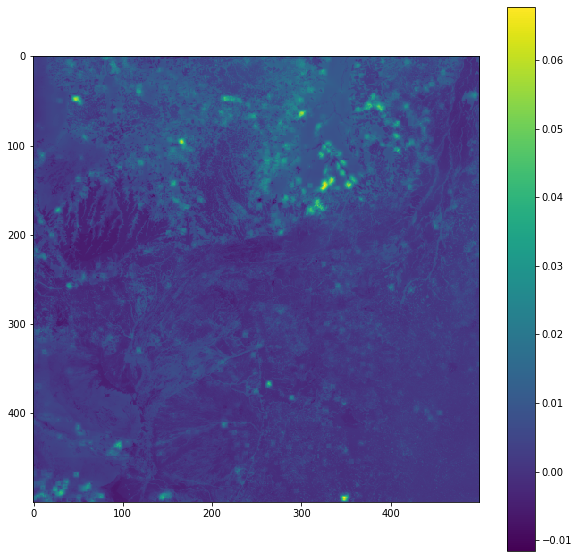

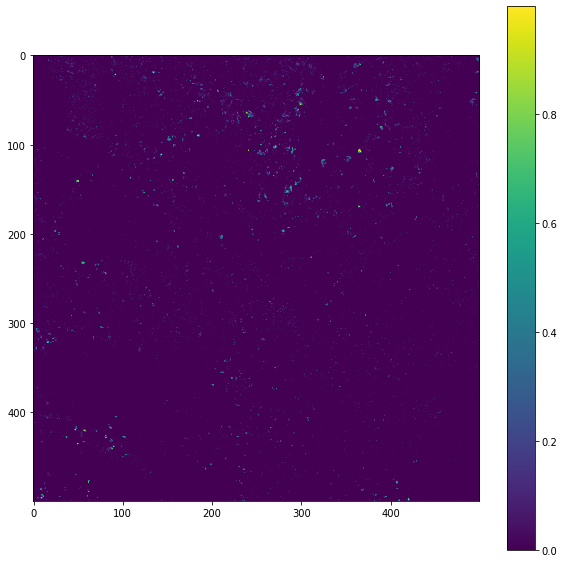

In [22]:
plt.figure(figsize = (10, 10))
plt.imshow(pred.reshape(500, 500))
plt.colorbar()
plt.show()
plt.imshow(y_test_true.reshape(500, 500))
plt.colorbar()
plt.show()